# DL development pipeline

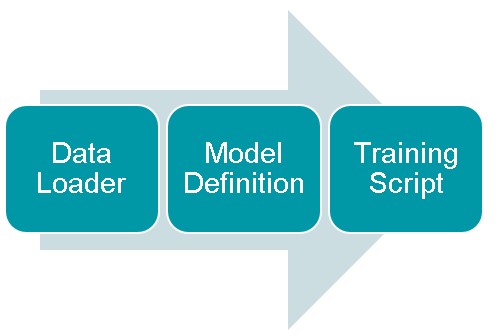

# Sequential

```
# From https://www.tensorflow.org/guide/keras/sequential_model
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
y = model(x)
```

A Sequential model is not appropriate when:

*   Your model has multiple inputs or multiple outputs
*   Any of your layers has multiple inputs or multiple outputs

*   You need to do layer sharing
*   You want non-linear topology (e.g. a residual connection, a multi-branch model)

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
def get_sequential_model(input_shape): 
    model = keras.Sequential(
        [
            # Input
            layers.Input(input_shape),
            
            # 1st Conv block
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            # 2nd Conv block
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),           
            
            # Classifier
            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ]
    )
    
    return model
    

input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     1

# Functional

In [3]:
def get_functional_model(input_shape):
    inputs = keras.Input(input_shape)
    
    # 1st Conv block
    x = layers.Conv2D(64, 3, strides=1, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, 3, strides=1, activation='relu', padding='same')(x)
    x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # 2nd Conv block
    x = layers.Conv2D(128, 3, strides=1, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, strides=1, activation='relu', padding='same')(x)
    x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Classifier
    x = layers.GlobalMaxPool2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    
    return model

input_shape = (256, 256, 3)
model = get_functional_model(input_shape)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 128)    

# Model subclassing

*   It exposes built-in training, evaluation, and prediction loops `(model.fit(), model.evaluate(), model.predict())`.
*   It exposes the list of its inner layers, via the model.layers property.
*   It exposes saving and serialization APIs (`save()`, `save_weights()`...)





In [6]:
class SimpleCNN(keras.Model):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv_block_1 = keras.Sequential(
            [
                layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
                layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
                layers.MaxPool2D(),
                layers.BatchNormalization(),
                layers.Dropout(0.5)             
            ], name='conv_block_1'
        )
        
        self.conv_block_2 = keras.Sequential(
            [
                layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
                layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
                layers.MaxPool2D(),
                layers.BatchNormalization(),
                layers.Dropout(0.3)                        
            ], name='conv_block_2'
        )
        
        self.classifier = keras.Sequential(
            [
                layers.GlobalMaxPool2D(),
                layers.Dense(128, activation='relu'),
                layers.Dense(1, activation='sigmoid')
            ], name='classifier'
        )
    
    def call(self, input_tensor, training=False):
        x = self.conv_block_1(input_tensor)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        
        return x

In [7]:
input_shape = (None, 256, 256, 3)
model = SimpleCNN()
model.build(input_shape)

model.summary()

Model: "simple_cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_block_1 (Sequential)    (None, 128, 128, 64)      38976     
_________________________________________________________________
conv_block_2 (Sequential)    (None, 64, 64, 128)       221952    
_________________________________________________________________
classifier (Sequential)      (None, 1)                 16641     
Total params: 277,569
Trainable params: 277,185
Non-trainable params: 384
_________________________________________________________________


# Model compiling

In [8]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='accuracy'
)